<a href="https://colab.research.google.com/github/kimsun75/dataAnalysis/blob/main/3_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EB%B6%84%EB%A5%98_4_%EB%94%A5%EB%9F%AC%EB%8B%9D_%ED%98%B8%ED%85%94%EC%98%88%EC%95%BD%EC%B7%A8%EC%86%8C%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 호텔 예약 취소여부 예측 - 분류




## 문제 정의
* 과제 목적
    - 사전에 객실 수요 파악하여 효율적인 객실 관리

* 과제 목표
    - 호텔 예약 취소 여부 예측 -> 사전에 취소될 가능성이 큰 객실 예측하기

### #그래프에서 한글사용하는 방법
- **(코랩에서)한글폰트 설치하기**

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 코랩에서 위 코드를 실행시킨 후  반드시 코랩 메뉴: "런타임>런타임 다시 시작" 합니다.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (9,799 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121918 files and dire

- **한글 폰트 지정하기**

In [1]:
# 코랩에서 한글 폰트 종류와 이름이 win과 다를 수 있다!!!
# 코랩: NanumGothic, 윈도우: Malgun Gothic
import matplotlib.pyplot as plt
plt.rcParams.update({'font.family': 'NanumGothic',
                     'font.size': 12,
                     'figure.figsize': (6, 4),
                     'axes.unicode_minus':  False }) # 폰트 설정



---



## 1. 데이터 가져오기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
print(f'현재 디렉토리: {os.getcwd()}')

현재 디렉토리: /content


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1.데이터 가져오기
file_path = '/content/drive/My Drive/0_datdasets/hotelbooking/hotel_bookings.csv'
df = pd.read_csv(file_path)

# 2.데이터 전처리
## 결측치 처리
# data.fillna({'children': 0, 'company': 0, 'agent': 0}, inplace=True)
df['children'].fillna(df['children'].median(), inplace=True) # children(float64) 4건,  중앙값으로
df['country'].fillna(df['country'].mode()[0], inplace=True)  # country(object) 488건, 최빈값으로
df.drop(['agent','company'], axis=1, inplace=True)  # agent 16340건, company 112593건 컬럼 삭제
df.dropna(inplace=True)


# 독립변수, 종속변수 지정(features and target)
features = [
    'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number',
    'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights',
    'adults', 'children', 'babies', 'meal', 'country', 'market_segment',
    'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
    'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type',
    'booking_changes', 'deposit_type', 'days_in_waiting_list',
    'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests'
]
target = 'is_canceled'
X = df[features]
y = df[target]


# 훈련 및 테스트 세트로 분(Split into train and test sets)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


# 범주형 변수와 수치형 변수를 구분
categorical_features = [
    'arrival_date_month', 'meal', 'country', 'market_segment',
    'distribution_channel', 'reserved_room_type', 'assigned_room_type',
    'deposit_type', 'customer_type'
]
numerical_features = [
    'lead_time', 'arrival_date_year', 'arrival_date_week_number',
    'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights',
    'adults', 'children', 'babies', 'previous_cancellations',
    'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list',
    'adr', 'required_car_parking_spaces', 'total_of_special_requests'
]
# 컬럼 변환기를 통한 전처리(스케일링과 인코딩))
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)
# Apply preprocessing to training and test data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
# print(X_train[:5])

# Convert target to categorical (binary classification)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
# print(y_train[:5])


# 딥러닝 네트워크 레이어 정의(Define the neural network model)
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습하기(Train the model)
## val_loss 모니터링해서 성능이 5번 지나도록 좋아지지 않으면 조기 종료하기
early_stop = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=5, restore_best_weights=True)

## val_loss가 가장 낮은 값을 가질 때마다 모델 저장하기
check_point = ModelCheckpoint('best_model.h5', verbose=1,
                              monitor='val_loss', mode='min', save_best_only=True)

## 모델 학습하기
# history = model.fit(X_train, y_train, epochs=20, batch_size=32,validation_data=(X_test, y_test))
history = model.fit(X_train, y_train, epochs=100, batch_size=128,
                    validation_data=(X_test, y_test), verbose=1,
                    callbacks=[early_stop, check_point])

# 모델 평가 및 예측(Evaluate the model)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# 최종 분류 결과 보고서(Display classification report)
print('Classification report:', classification_report(y_test_classes, y_pred_classes))

(95512, 26) (95512,)
(23878, 26) (23878,)
Epoch 1/100
736/747 [============================>.] - ETA: 0s - loss: 0.4034 - accuracy: 0.8068
Epoch 1: val_loss improved from inf to 0.33166, saving model to best_model.h5
747/747 [==============================] - 8s 9ms/step - loss: 0.4025 - accuracy: 0.8075 - val_loss: 0.3317 - val_accuracy: 0.8433
Epoch 2/100
747/747 [==============================] - ETA: 0s - loss: 0.3438 - accuracy: 0.8389
Epoch 2: val_loss improved from 0.33166 to 0.31761, saving model to best_model.h5
747/747 [==============================] - 4s 6ms/step - loss: 0.3438 - accuracy: 0.8389 - val_loss: 0.3176 - val_accuracy: 0.8514
Epoch 3/100
746/747 [============================>.] - ETA: 0s - loss: 0.3300 - accuracy: 0.8458
Epoch 3: val_loss improved from 0.31761 to 0.30810, saving model to best_model.h5
747/747 [==============================] - 6s 8ms/step - loss: 0.3300 - accuracy: 0.8458 - val_loss: 0.3081 - val_accuracy: 0.8536
Epoch 4/100
738/747 [===========

In [ ]:
# 모델 요약 정보
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                15936     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 18,082
Trainable params: 18,082
Non-trainable params: 0
_________________________________________________________________


### **모델 그래프**

- 학습 곡선 그래프 출력

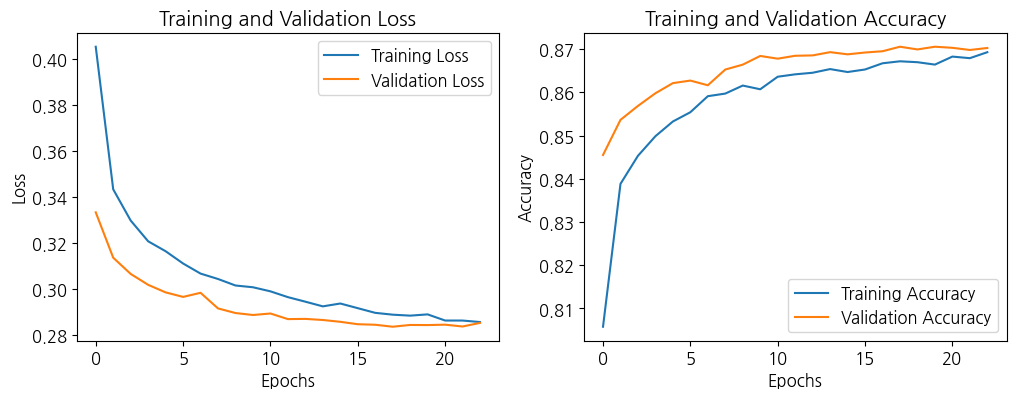

In [ ]:
# 학습 곡선 그래프 출력
def plot_learning_curve(history):
    # 손실 그래프
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.show()

# 학습 곡선 그래프 출력 함수 호출
plot_learning_curve(history)

- (분류)모델 성능 그래프

     accuracy  recall  precision    f1
DNN     0.871   0.858      0.785  0.82


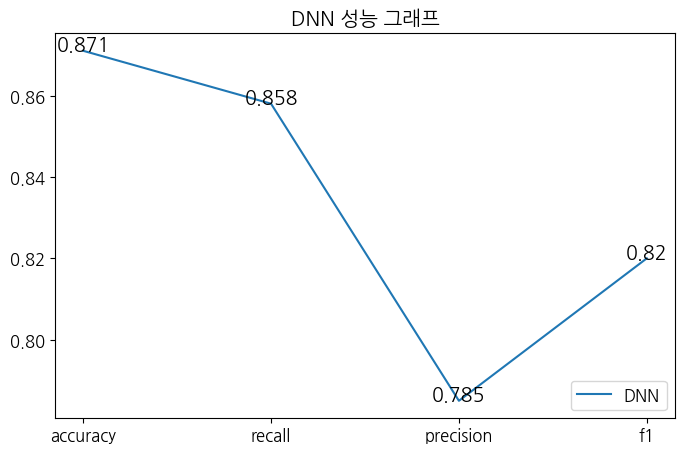

In [ ]:
# 분류 모델 성능 그래프
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

result = pd.DataFrame([], columns=['accuracy', 'recall', 'precision', 'f1'])

# 파라미터
# model_name :  모델 이름(str)
# pred: 예측 결과

# actual: 실제값(y_test)
def result_view(model_name, pred, actual):
    # 정확도
    accuracy = round(accuracy_score(actual, pred), 3)
    # 재현율
    recall = round(recall_score(actual, pred), 3)
    # 정밀도
    precision = round(precision_score(actual, pred), 3)
    # f1-score
    f1 = round(f1_score(actual, pred), 3)

    result.loc[model_name] = [accuracy, recall, precision, f1]

    result.sort_values(by='accuracy', ascending=False, inplace=True)
    print(result)

    plt.figure(figsize=(8, 5))
    for idx in result.index:
        x_values = result.columns    # x축
        y_values = result.loc[idx]   # y축
        plt.plot(x_values, y_values) # 선 그래프
        plt.annotate(text=round(result.loc[idx,'accuracy'], 3), xy=(0, result.loc[idx,'accuracy']),
                     xytext=(0, result.loc[idx,'accuracy']), ha= 'center', fontsize=14)
        plt.annotate(text=round(result.loc[idx,'recall'], 3), xy=(1, result.loc[idx,'recall']),
                     xytext=(1, result.loc[idx,'recall']), ha= 'center', fontsize=14)
        plt.annotate(text=round(result.loc[idx,'precision'], 3), xy=(2, result.loc[idx,'precision']),
                     xytext=(2, result.loc[idx,'precision']), ha= 'center', fontsize=14)
        plt.annotate(text=round(result.loc[idx,'f1'], 3), xy=(3, result.loc[idx,'f1']),
                     xytext=(3, result.loc[idx,'f1']), ha= 'center', fontsize=14)

    plt.legend(result.index, loc=4)
    plt.title(f'{model_name} 성능 그래프')
    plt.show()

# 모델 평가지표 비교 함수 호출
result_view('DNN', y_test_classes, y_pred_classes)



---



끝